In [1]:
%pip install timm==0.4.12

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 377.0/377.0 KB 2.9 MB/s eta 0:00:00 MB/s eta 0:00:01:01
  Attempting uninstall: timm
    Found existing installation: timm 0.3.2
    Uninstalling timm-0.3.2:
      Successfully uninstalled timm-0.3.2
Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
from torch import nn
from einops import rearrange

from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import GradScaler,autocast
import torch.optim as optim

import sys
import os
import time
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder , OneHotEncoder
from sklearn.model_selection import train_test_split

/tmp/ipykernel_46243/3799284888.py:14: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
root_path = r"/home/srikanth/Dataset/RGB_images"
dataset_path = os.listdir(root_path)
dataset_path

['Palmar wrist pronated', 'Pinch', 'Tripod', 'Palmar wrist neutral']

In [5]:
class_labels = []


for item in dataset_path:
    #print(item)
    all_objects = os.listdir(root_path + '/' +item)
    for top_object in all_objects:
        sub_objects = os.listdir(root_path  + '/' +item + '/' +top_object)
        for sub_object in sub_objects:
            images = os.listdir(root_path + '/' +item + '/' +top_object + '/' +sub_object)
            for image in images:
                class_labels.append((item,str(root_path + '/' +item + '/' +top_object + '/' +sub_object +'/' +image)))
# class_labels
df = pd.DataFrame(data=class_labels, columns=['labels', 'image'])
# df
y=list(df['labels'].values)
# y
image=df['image']
# image

In [6]:
images, y= shuffle(image,y, random_state=1)
train_x, test_x, train_y, test_y = train_test_split(images, y, test_size=0.2, random_state=415)
test_x = test_x.reset_index(drop=True)
train_x = train_x.reset_index(drop=True)
test_x, val_x, test_y, val_y = train_test_split(test_x,test_y, test_size=0.5, random_state=415)
test_x = test_x.reset_index(drop=True)
#train_y=list(train_y)
train_df=pd.DataFrame({'filepaths':train_x,'labels':train_y})
valid_df=pd.DataFrame({'filepaths':val_x,'labels':val_y})
test_df=pd.DataFrame({'filepaths':test_x,'labels':test_y})

In [7]:
classes=list(train_df['labels'].unique())
class_count=len(classes)

In [8]:
labels = df['labels'].unique()
num_labels = len(labels)
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

print(label2id)
print(id2label)

{'Palmar wrist pronated': 0, 'Pinch': 1, 'Tripod': 2, 'Palmar wrist neutral': 3}
{0: 'Palmar wrist pronated', 1: 'Pinch', 2: 'Tripod', 3: 'Palmar wrist neutral'}


In [9]:
class ImageDataset():
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((64, 64), antialias=True),
        transforms.Normalize( mean= [0.51158103, 0.47950193, 0.46153474],
                             std=[0.22355489, 0.22948845, 0.24873442])
        ])
        self.label_mapping = label2id
    # class ImageDataset(Dataset):
    # def __init__(self, df, label2id, input_size=224, transform=None):
    #     self.df = df
    #     self.label_mapping = label2id
    #     resize_value = self.calculate_resize_value(input_size)
    #     self.transform = transform if transform else transforms.Compose([
    #         transforms.Resize((resize_value, resize_value), antialias=True),
    #         transforms.CenterCrop(input_size),
    #         transforms.ToTensor(),
    #         transforms.Normalize(mean=[0.51158103, 0.47950193, 0.46153474],
    #                              std=[0.22355489, 0.22948845, 0.24873442])
    #     ])

    # def calculate_resize_value(self, input_size):
    #     return int((256 / 224) * input_size)

    def __len__(self):
        return len(self.df)

    def get_images(self, idx):
        return self.transform(Image.open(self.df.iloc[idx]['filepaths']))

    def get_labels(self, idx):
        label = self.df.iloc[idx]['labels']
        return torch.tensor(self.label_mapping[label], dtype=torch.long)

    def __getitem__(self, idx):
        train_images = self.get_images(idx)
        train_labels = self.get_labels(idx)

        return train_images, train_labels

In [10]:
train_dataset = ImageDataset(train_df, transform=transforms)
val_dataset = ImageDataset(valid_df, transform=transforms)
test_dataset = ImageDataset(test_df, transform=transforms)

In [11]:
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

MODEL

In [12]:
%pip install deepspeed

Note: you may need to restart the kernel to use updated packages.


In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from functools import partial
from timm.models.layers import DropPath, trunc_normal_

class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x


class Attention(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False, qk_scale=None, attn_drop=0., proj_drop=0.):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        # NOTE scale factor was wrong in my original version, can set manually to be compat with prev weights
        self.scale = qk_scale or head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]  # make torchscript happy (cannot use tensor as tuple)

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x


class Block(nn.Module):

    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., act_layer=nn.GELU, norm_layer=partial(nn.LayerNorm, eps=1e-6)):
        super().__init__()
        self.norm1 = norm_layer(dim)
        self.attn = Attention(
            dim, num_heads=num_heads, qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop)
        # NOTE: drop path for stochastic depth, we shall see if this is better than dropout here
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

    def forward(self, x):
        x = x + self.drop_path(self.attn(self.norm1(x)))
        x = x + self.drop_path(self.mlp(self.norm2(x)))
        return x


class ConvBlock(nn.Module):

    def __init__(self, inplanes, outplanes, stride=1, res_conv=False, act_layer=nn.ReLU, groups=1,
                 norm_layer=partial(nn.BatchNorm2d, eps=1e-6), drop_block=None, drop_path=None):
        super(ConvBlock, self).__init__()

        expansion = 4
        med_planes = outplanes // expansion

        self.conv1 = nn.Conv2d(inplanes, med_planes, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn1 = norm_layer(med_planes)
        self.act1 = act_layer(inplace=True)

        self.conv2 = nn.Conv2d(med_planes, med_planes, kernel_size=3, stride=stride, groups=groups, padding=1, bias=False)
        self.bn2 = norm_layer(med_planes)
        self.act2 = act_layer(inplace=True)

        self.conv3 = nn.Conv2d(med_planes, outplanes, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn3 = norm_layer(outplanes)
        self.act3 = act_layer(inplace=True)

        if res_conv:
            self.residual_conv = nn.Conv2d(inplanes, outplanes, kernel_size=1, stride=stride, padding=0, bias=False)
            self.residual_bn = norm_layer(outplanes)

        self.res_conv = res_conv
        self.drop_block = drop_block
        self.drop_path = drop_path

    def zero_init_last_bn(self):
        nn.init.zeros_(self.bn3.weight)

    def forward(self, x, x_t=None, return_x_2=True):
        residual = x

        x = self.conv1(x)
        x = self.bn1(x)
        if self.drop_block is not None:
            x = self.drop_block(x)
        x = self.act1(x)

        x = self.conv2(x) if x_t is None else self.conv2(x + x_t)
        x = self.bn2(x)
        if self.drop_block is not None:
            x = self.drop_block(x)
        x2 = self.act2(x)

        x = self.conv3(x2)
        x = self.bn3(x)
        if self.drop_block is not None:
            x = self.drop_block(x)

        if self.drop_path is not None:
            x = self.drop_path(x)

        if self.res_conv:
            residual = self.residual_conv(residual)
            residual = self.residual_bn(residual)

        x += residual
        x = self.act3(x)

        if return_x_2:
            return x, x2
        else:
            return x


class FCUDown(nn.Module):
    """ CNN feature maps -> Transformer patch embeddings
    """

    def __init__(self, inplanes, outplanes, dw_stride, act_layer=nn.GELU,
                 norm_layer=partial(nn.LayerNorm, eps=1e-6)):
        super(FCUDown, self).__init__()
        self.dw_stride = dw_stride

        self.conv_project = nn.Conv2d(inplanes, outplanes, kernel_size=1, stride=1, padding=0)
        self.sample_pooling = nn.AvgPool2d(kernel_size=dw_stride, stride=dw_stride)

        self.ln = norm_layer(outplanes)
        self.act = act_layer()

    def forward(self, x, x_t):
        x = self.conv_project(x)  # [N, C, H, W]

        x = self.sample_pooling(x).flatten(2).transpose(1, 2)
        x = self.ln(x)
        x = self.act(x)

        x = torch.cat([x_t[:, 0][:, None, :], x], dim=1)

        return x


class FCUUp(nn.Module):
    """ Transformer patch embeddings -> CNN feature maps
    """

    def __init__(self, inplanes, outplanes, up_stride, act_layer=nn.ReLU,
                 norm_layer=partial(nn.BatchNorm2d, eps=1e-6),):
        super(FCUUp, self).__init__()

        self.up_stride = up_stride
        self.conv_project = nn.Conv2d(inplanes, outplanes, kernel_size=1, stride=1, padding=0)
        self.bn = norm_layer(outplanes)
        self.act = act_layer()

    def forward(self, x, H, W):
        B, _, C = x.shape
        # [N, 197, 384] -> [N, 196, 384] -> [N, 384, 196] -> [N, 384, 14, 14]
        x_r = x[:, 1:].transpose(1, 2).reshape(B, C, H, W)
        x_r = self.act(self.bn(self.conv_project(x_r)))

        return F.interpolate(x_r, size=(H * self.up_stride, W * self.up_stride))


class Med_ConvBlock(nn.Module):
    """ special case for Convblock with down sampling,
    """
    def __init__(self, inplanes, act_layer=nn.ReLU, groups=1, norm_layer=partial(nn.BatchNorm2d, eps=1e-6),
                 drop_block=None, drop_path=None):

        super(Med_ConvBlock, self).__init__()

        expansion = 4
        med_planes = inplanes // expansion

        self.conv1 = nn.Conv2d(inplanes, med_planes, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn1 = norm_layer(med_planes)
        self.act1 = act_layer(inplace=True)

        self.conv2 = nn.Conv2d(med_planes, med_planes, kernel_size=3, stride=1, groups=groups, padding=1, bias=False)
        self.bn2 = norm_layer(med_planes)
        self.act2 = act_layer(inplace=True)

        self.conv3 = nn.Conv2d(med_planes, inplanes, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn3 = norm_layer(inplanes)
        self.act3 = act_layer(inplace=True)

        self.drop_block = drop_block
        self.drop_path = drop_path

    def zero_init_last_bn(self):
        nn.init.zeros_(self.bn3.weight)

    def forward(self, x):
        residual = x

        x = self.conv1(x)
        x = self.bn1(x)
        if self.drop_block is not None:
            x = self.drop_block(x)
        x = self.act1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        if self.drop_block is not None:
            x = self.drop_block(x)
        x = self.act2(x)

        x = self.conv3(x)
        x = self.bn3(x)
        if self.drop_block is not None:
            x = self.drop_block(x)

        if self.drop_path is not None:
            x = self.drop_path(x)

        x += residual
        x = self.act3(x)

        return x


class ConvTransBlock(nn.Module):
    """
    Basic module for ConvTransformer, keep feature maps for CNN block and patch embeddings for transformer encoder block
    """

    def __init__(self, inplanes, outplanes, res_conv, stride, dw_stride, embed_dim, num_heads=12, mlp_ratio=4.,
                 qkv_bias=False, qk_scale=None, drop_rate=0., attn_drop_rate=0., drop_path_rate=0.,
                 last_fusion=False, num_med_block=0, groups=1):

        super(ConvTransBlock, self).__init__()
        expansion = 4
        self.cnn_block = ConvBlock(inplanes=inplanes, outplanes=outplanes, res_conv=res_conv, stride=stride, groups=groups)

        if last_fusion:
            self.fusion_block = ConvBlock(inplanes=outplanes, outplanes=outplanes, stride=2, res_conv=True, groups=groups)
        else:
            self.fusion_block = ConvBlock(inplanes=outplanes, outplanes=outplanes, groups=groups)

        if num_med_block > 0:
            self.med_block = []
            for i in range(num_med_block):
                self.med_block.append(Med_ConvBlock(inplanes=outplanes, groups=groups))
            self.med_block = nn.ModuleList(self.med_block)

        self.squeeze_block = FCUDown(inplanes=outplanes // expansion, outplanes=embed_dim, dw_stride=dw_stride)

        self.expand_block = FCUUp(inplanes=embed_dim, outplanes=outplanes // expansion, up_stride=dw_stride)

        self.trans_block = Block(
            dim=embed_dim, num_heads=num_heads, mlp_ratio=mlp_ratio, qkv_bias=qkv_bias, qk_scale=qk_scale,
            drop=drop_rate, attn_drop=attn_drop_rate, drop_path=drop_path_rate)

        self.dw_stride = dw_stride
        self.embed_dim = embed_dim
        self.num_med_block = num_med_block
        self.last_fusion = last_fusion

    def forward(self, x, x_t):
        x, x2 = self.cnn_block(x)

        _, _, H, W = x2.shape

        x_st = self.squeeze_block(x2, x_t)

        x_t = self.trans_block(x_st + x_t)

        if self.num_med_block > 0:
            for m in self.med_block:
                x = m(x)

        x_t_r = self.expand_block(x_t, H // self.dw_stride, W // self.dw_stride)
        x = self.fusion_block(x, x_t_r, return_x_2=False)

        return x, x_t



CONFORMER


In [15]:
class Conformer(nn.Module):

    def __init__(self, patch_size=16, in_chans=3, num_classes=1000, base_channel=64, channel_ratio=4, num_med_block=0,
                 embed_dim=768, depth=12, num_heads=12, mlp_ratio=4., qkv_bias=False, qk_scale=None,
                 drop_rate=0., attn_drop_rate=0., drop_path_rate=0.):

        # Transformer
        super().__init__()
        self.num_classes = num_classes
        self.num_features = self.embed_dim = embed_dim  # num_features for consistency with other models
        assert depth % 3 == 0

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.trans_dpr = [x.item() for x in torch.linspace(0, drop_path_rate, depth)]  # stochastic depth decay rule

        # Classifier head
        self.trans_norm = nn.LayerNorm(embed_dim)
        self.trans_cls_head = nn.Linear(embed_dim, num_classes) if num_classes > 0 else nn.Identity()
        self.pooling = nn.AdaptiveAvgPool2d(1)
        self.conv_cls_head = nn.Linear(int(256 * channel_ratio), num_classes)

        # Stem stage: get the feature maps by conv block (copied form resnet.py)
        self.conv1 = nn.Conv2d(in_chans, 64, kernel_size=7, stride=2, padding=3, bias=False)  # 1 / 2 [112, 112]
        self.bn1 = nn.BatchNorm2d(64)
        self.act1 = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)  # 1 / 4 [56, 56]

        # 1 stage
        stage_1_channel = int(base_channel * channel_ratio)
        trans_dw_stride = patch_size // 4
        self.conv_1 = ConvBlock(inplanes=64, outplanes=stage_1_channel, res_conv=True, stride=1)
        self.trans_patch_conv = nn.Conv2d(64, embed_dim, kernel_size=trans_dw_stride, stride=trans_dw_stride, padding=0)
        self.trans_1 = Block(dim=embed_dim, num_heads=num_heads, mlp_ratio=mlp_ratio, qkv_bias=qkv_bias,
                             qk_scale=qk_scale, drop=drop_rate, attn_drop=attn_drop_rate, drop_path=self.trans_dpr[0],
                             )

        # 2~4 stage
        init_stage = 2
        fin_stage = depth // 3 + 1
        for i in range(init_stage, fin_stage):
            self.add_module('conv_trans_' + str(i),
                    ConvTransBlock(
                        stage_1_channel, stage_1_channel, False, 1, dw_stride=trans_dw_stride, embed_dim=embed_dim,
                        num_heads=num_heads, mlp_ratio=mlp_ratio, qkv_bias=qkv_bias, qk_scale=qk_scale,
                        drop_rate=drop_rate, attn_drop_rate=attn_drop_rate, drop_path_rate=self.trans_dpr[i-1],
                        num_med_block=num_med_block
                    )
            )


        stage_2_channel = int(base_channel * channel_ratio * 2)
        # 5~8 stage
        init_stage = fin_stage # 5
        fin_stage = fin_stage + depth // 3 # 9
        for i in range(init_stage, fin_stage):
            s = 2 if i == init_stage else 1
            in_channel = stage_1_channel if i == init_stage else stage_2_channel
            res_conv = True if i == init_stage else False
            self.add_module('conv_trans_' + str(i),
                    ConvTransBlock(
                        in_channel, stage_2_channel, res_conv, s, dw_stride=trans_dw_stride // 2, embed_dim=embed_dim,
                        num_heads=num_heads, mlp_ratio=mlp_ratio, qkv_bias=qkv_bias, qk_scale=qk_scale,
                        drop_rate=drop_rate, attn_drop_rate=attn_drop_rate, drop_path_rate=self.trans_dpr[i-1],
                        num_med_block=num_med_block
                    )
            )

        stage_3_channel = int(base_channel * channel_ratio * 2 * 2)
        # 9~12 stage
        init_stage = fin_stage  # 9
        fin_stage = fin_stage + depth // 3  # 13
        for i in range(init_stage, fin_stage):
            s = 2 if i == init_stage else 1
            in_channel = stage_2_channel if i == init_stage else stage_3_channel
            res_conv = True if i == init_stage else False
            last_fusion = True if i == depth else False
            self.add_module('conv_trans_' + str(i),
                    ConvTransBlock(
                        in_channel, stage_3_channel, res_conv, s, dw_stride=trans_dw_stride // 4, embed_dim=embed_dim,
                        num_heads=num_heads, mlp_ratio=mlp_ratio, qkv_bias=qkv_bias, qk_scale=qk_scale,
                        drop_rate=drop_rate, attn_drop_rate=attn_drop_rate, drop_path_rate=self.trans_dpr[i-1],
                        num_med_block=num_med_block, last_fusion=last_fusion
                    )
            )
        self.fin_stage = fin_stage

        trunc_normal_(self.cls_token, std=.02)

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        elif isinstance(m, nn.BatchNorm2d):
            nn.init.constant_(m.weight, 1.)
            nn.init.constant_(m.bias, 0.)
        elif isinstance(m, nn.GroupNorm):
            nn.init.constant_(m.weight, 1.)
            nn.init.constant_(m.bias, 0.)

    @torch.jit.ignore
    def no_weight_decay(self):
        return {'cls_token'}


    def forward(self, x):
        B = x.shape[0]
        cls_tokens = self.cls_token.expand(B, -1, -1)

        # pdb.set_trace()
        # stem stage [N, 3, 224, 224] -> [N, 64, 56, 56]
        x_base = self.maxpool(self.act1(self.bn1(self.conv1(x))))

        # 1 stage
        x = self.conv_1(x_base, return_x_2=False)

        x_t = self.trans_patch_conv(x_base).flatten(2).transpose(1, 2)
        x_t = torch.cat([cls_tokens, x_t], dim=1)
        x_t = self.trans_1(x_t)
        
        # 2 ~ final 
        for i in range(2, self.fin_stage):
            x, x_t = eval('self.conv_trans_' + str(i))(x, x_t)

        # conv classification
        x_p = self.pooling(x).flatten(1)
        conv_cls = self.conv_cls_head(x_p)

        # trans classification
        x_t = self.trans_norm(x_t)
        tran_cls = self.trans_cls_head(x_t[:, 0])

        return [conv_cls, tran_cls]

In [16]:
model = Conformer(patch_size=16, channel_ratio=6, embed_dim=576, depth=12,
                      num_heads=9, mlp_ratio=4, qkv_bias=True)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001,  weight_decay=0.01)
criterion = nn.CrossEntropyLoss()
num_epochs = 40

In [17]:
from tqdm import tqdm
import torch

def trainVal(model, criterion, optimizer, num_epochs, min_val_loss, train_loader, val_loader, device):
    best_acc = 0.0
    min_loss = min_val_loss

    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        model.train()  # Set model to training mode
        running_loss = 0.0
        running_corrects = 0

        # Using tqdm for progress tracking
        for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch}', leave=False):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(True):
                outputs = model(inputs)
                if isinstance(outputs, list):
                    loss_list = [criterion(o, labels) / len(outputs) for o in outputs]
                    loss = sum(loss_list)
                    preds = torch.max(outputs[0] + outputs[1], 1)[1]
                else:
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                # backward + optimize only if in training phase
                loss.backward()
                optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)

        train_losses.append(epoch_loss)
        train_accs.append(epoch_acc)
        print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # Validation phase
        model.eval()  # Set model to evaluate mode
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            with torch.no_grad():
                outputs = model(inputs)
                if isinstance(outputs, list):
                    loss_list = [criterion(o, labels) / len(outputs) for o in outputs]
                    loss = sum(loss_list)
                    preds = torch.max(outputs[0] + outputs[1], 1)[1]
                else:
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(val_loader.dataset)
        epoch_acc = running_corrects.double() / len(val_loader.dataset)

        val_losses.append(epoch_loss)
        val_accs.append(epoch_acc)
        print(f'Val Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # Update the learning rate
        # scheduler.step()  # Uncomment if using a learning rate scheduler

        # Save the model if it has the best validation accuracy so far
        if epoch_acc > best_acc:
            best_acc = epoch_acc
            state = {
                'epoch': epoch + 1,
                'state_dict': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'min_loss': epoch_loss
            }
        torch.save(state, 'weight/conformer-wwc-rgbd.pth')

    return train_losses, train_accs, val_losses, val_accs, min_loss


In [18]:
# Define the initial minimum validation loss
min_val_loss = float('inf')

# Call the training function with the appropriate data loaders
train_losses, train_accs, val_losses, val_accs, min_loss = trainVal(
    model, criterion, optimizer, num_epochs, min_val_loss, train_loader, val_loader, device
)

Epoch 0/39
----------


Train Loss: 0.4510 Acc: 0.8869
Val Loss: 0.2033 Acc: 0.9645
Epoch 1/39
----------


Train Loss: 0.1684 Acc: 0.9644
Val Loss: 0.0692 Acc: 0.9850
Epoch 2/39
----------


Train Loss: 0.1118 Acc: 0.9753
Val Loss: 0.0483 Acc: 0.9884
Epoch 3/39
----------


Train Loss: 0.0937 Acc: 0.9789
Val Loss: 0.0559 Acc: 0.9892
Epoch 4/39
----------


Train Loss: 0.0834 Acc: 0.9810
Val Loss: 0.0721 Acc: 0.9826
Epoch 5/39
----------


Train Loss: 0.0781 Acc: 0.9819
Val Loss: 0.0614 Acc: 0.9839
Epoch 6/39
----------


Train Loss: 0.0722 Acc: 0.9830
Val Loss: 0.0685 Acc: 0.9816
Epoch 7/39
----------


Train Loss: 0.0705 Acc: 0.9833
Val Loss: 0.0399 Acc: 0.9902
Epoch 8/39
----------


Train Loss: 0.0685 Acc: 0.9836
Val Loss: 0.0330 Acc: 0.9895
Epoch 9/39
----------


Train Loss: 0.0670 Acc: 0.9835
Val Loss: 0.0429 Acc: 0.9894
Epoch 10/39
----------


Train Loss: 0.0636 Acc: 0.9845
Val Loss: 0.0398 Acc: 0.9892
Epoch 11/39
----------


Train Loss: 0.0631 Acc: 0.9846
Val Loss: 0.0287 Acc: 0.9915
Epoch 12/39
----------


Train Loss: 0.0623 Acc: 0.9850
Val Loss: 0.0409 Acc: 0.9903
Epoch 13/39
----------


Train Loss: 0.0610 Acc: 0.9850
Val Loss: 0.0461 Acc: 0.9857
Epoch 14/39
----------


Train Loss: 0.0604 Acc: 0.9853
Val Loss: 0.0372 Acc: 0.9901
Epoch 15/39
----------


Train Loss: 0.0602 Acc: 0.9854
Val Loss: 0.0393 Acc: 0.9893
Epoch 16/39
----------


Train Loss: 0.0594 Acc: 0.9850
Val Loss: 0.0446 Acc: 0.9892
Epoch 17/39
----------


Train Loss: 0.0590 Acc: 0.9854
Val Loss: 0.0365 Acc: 0.9896
Epoch 18/39
----------


Train Loss: 0.0585 Acc: 0.9850
Val Loss: 0.0373 Acc: 0.9904
Epoch 19/39
----------


Train Loss: 0.0585 Acc: 0.9851
Val Loss: 0.0379 Acc: 0.9899
Epoch 20/39
----------


Train Loss: 0.0565 Acc: 0.9859
Val Loss: 0.0299 Acc: 0.9908
Epoch 21/39
----------


Train Loss: 0.0584 Acc: 0.9854
Val Loss: 0.0405 Acc: 0.9871
Epoch 22/39
----------


Train Loss: 0.0565 Acc: 0.9857
Val Loss: 0.0407 Acc: 0.9886
Epoch 23/39
----------


Train Loss: 0.0570 Acc: 0.9860
Val Loss: 0.0311 Acc: 0.9909
Epoch 24/39
----------


Train Loss: 0.0565 Acc: 0.9860
Val Loss: 0.0338 Acc: 0.9895
Epoch 25/39
----------


Train Loss: 0.0565 Acc: 0.9854
Val Loss: 0.0378 Acc: 0.9894
Epoch 26/39
----------


Train Loss: 0.0561 Acc: 0.9860
Val Loss: 0.0418 Acc: 0.9888
Epoch 27/39
----------


Train Loss: 0.0561 Acc: 0.9854
Val Loss: 0.0481 Acc: 0.9849
Epoch 28/39
----------


Train Loss: 0.0563 Acc: 0.9857
Val Loss: 0.0339 Acc: 0.9893
Epoch 29/39
----------


Train Loss: 0.0553 Acc: 0.9856
Val Loss: 0.0478 Acc: 0.9884
Epoch 30/39
----------


Train Loss: 0.0557 Acc: 0.9855
Val Loss: 0.0307 Acc: 0.9911
Epoch 31/39
----------


Train Loss: 0.0555 Acc: 0.9857
Val Loss: 0.0356 Acc: 0.9895
Epoch 32/39
----------


Train Loss: 0.0543 Acc: 0.9861
Val Loss: 0.0334 Acc: 0.9905
Epoch 33/39
----------


Train Loss: 0.0558 Acc: 0.9860
Val Loss: 0.0469 Acc: 0.9858
Epoch 34/39
----------


Train Loss: 0.0542 Acc: 0.9859
Val Loss: 0.0388 Acc: 0.9899
Epoch 35/39
----------


Train Loss: 0.0544 Acc: 0.9856
Val Loss: 0.0290 Acc: 0.9913
Epoch 36/39
----------


Train Loss: 0.0548 Acc: 0.9859
Val Loss: 0.0505 Acc: 0.9853
Epoch 37/39
----------


Train Loss: 0.0539 Acc: 0.9859
Val Loss: 0.0300 Acc: 0.9905
Epoch 38/39
----------


Train Loss: 0.0545 Acc: 0.9858
Val Loss: 0.0515 Acc: 0.9845
Epoch 39/39
----------


Train Loss: 0.0535 Acc: 0.9861
Val Loss: 0.0280 Acc: 0.9913


PLOTTING


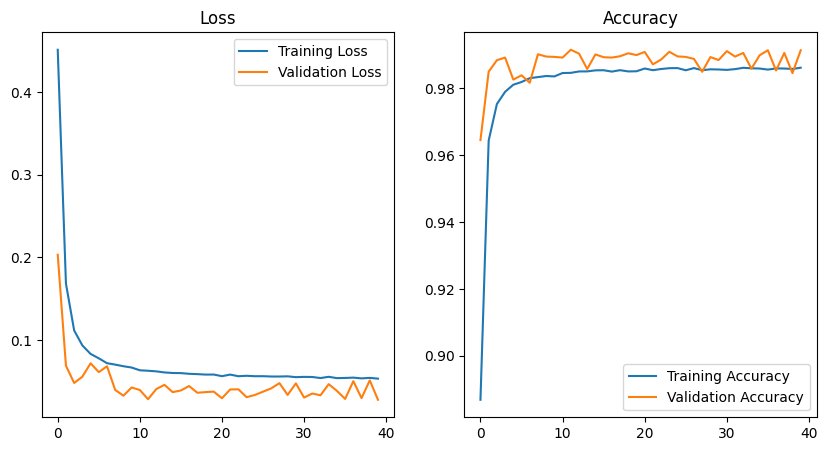

In [19]:
import matplotlib.pyplot as plt

# Convert the tensors to NumPy arrays

train_losses = torch.tensor(train_losses)
val_losses = torch.tensor(val_losses)
train_accs = torch.tensor(train_accs)
val_accs = torch.tensor(val_accs)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Training Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.show()

In [ ]:
# test_losses = []
# test_accuracies = []

# all_preds = []
# all_labels = []
# model.eval()
# total_test_loss = 0.0
# correct_test = 0
# with torch.no_grad():
#     for images, labels in test_loader:
#         images, labels = images.to(device), labels.to(device)
#         outputs = model(images)
#         test_loss = criterion(outputs, labels)
#         total_test_loss += test_loss.item() * images.size(0)
#         pred = outputs.argmax(dim=1, keepdim=True)
#         correct_test += pred.eq(labels.view_as(pred)).sum().item()
#         # Gather predictions and true labels for confusion matrix
#         all_preds.extend(pred.cpu().numpy())
#         all_labels.extend(labels.cpu().numpy())

# average_test_loss = total_test_loss / len(test_loader.dataset)
# test_losses.append(average_test_loss)
# test_accuracies.append(100. * correct_test / len(test_loader.dataset))
# print("Test Accuracy: {:.2f}%".format(test_accuracies[-1]))

In [21]:
test_losses = []
test_accuracies = []

all_preds = []
all_labels = []
model.eval()
total_test_loss = 0.0
correct_test = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        
        # If the model outputs a list of tensors
        if isinstance(outputs, list):
            batch_loss = 0.0
            for output in outputs:
                batch_loss += criterion(output, labels).item()
            test_loss = batch_loss / len(outputs)
            total_test_loss += test_loss * images.size(0)

            # For simplicity, assuming the first output for prediction evaluation
            output = outputs[0]
        else:
            test_loss = criterion(outputs, labels).item()
            total_test_loss += test_loss * images.size(0)
            output = outputs

        pred = output.argmax(dim=1, keepdim=True)
        correct_test += pred.eq(labels.view_as(pred)).sum().item()
        
        # Gather predictions and true labels for confusion matrix
        all_preds.extend(pred.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

average_test_loss = total_test_loss / len(test_loader.dataset)
test_losses.append(average_test_loss)
test_accuracies.append(100. * correct_test / len(test_loader.dataset))
print("Test Accuracy: {:.2f}%".format(test_accuracies[-1]))


Test Accuracy: 99.18%


In [22]:
from sklearn.metrics import confusion_matrix, classification_report
# Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:")
print(conf_matrix)
# Classification Report
class_report = classification_report(all_labels, all_preds)
print("Classification Report:")
print(class_report)

Confusion Matrix:
[[6347    0    0    9]
 [   3 3878    5    0]
 [   3    0 7002    0]
 [ 145    1    0 2811]]
Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      6356
           1       1.00      1.00      1.00      3886
           2       1.00      1.00      1.00      7005
           3       1.00      0.95      0.97      2957

    accuracy                           0.99     20204
   macro avg       0.99      0.99      0.99     20204
weighted avg       0.99      0.99      0.99     20204



In [23]:
import pickle
# Store the data in a dictionary
data = {
    'train_losses': train_losses,
    'train_accs': train_accs,
    'val_losses': val_losses,
    'val_accs': val_accs,
    'test_losses': test_losses,
    'test_accs': test_accuracies
}

# Save the data into a pickle file
with open('conformerwwcrgb.pkl','wb') as f:
    pickle.dump(data,f)